# Using Parent Hamiltonian Class

$$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$
$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$

Here we explain how to use the **Parent Hamiltonian** class of the module *parent_hamiltonian* of the library **PH** that can be use for computing Parent Hamiltonians of an input state



The main idea of the parent Hamiltonian is the following:

Given an ansatz represented by its state: $\ket{\Psi \left(\theta\right)}$, where $\theta$ is a vector of parameters, the parent Hamiltonian problem looks for a Hamiltonian $\mathcal{H}$ for the proposed ansatz which fundamental state and correspondent energy is 0. This is:

$$\mathcal{H}\ket{\Psi \left(\theta\right)} = 0 \tag{1}$$

In [ ]:
import logging
logging.basicConfig(
    format='%(asctime)s-%(levelname)s: %(message)s',
    datefmt='%m/%d/%Y %I:%M:%S %p',
    #level=logging.INFO
    level=logging.DEBUG
)
logger = logging.getLogger('__name__')

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import sys
sys.path.append("../")

In [ ]:
# myQLM qpus
from qat.qpus import PyLinalg, CLinalg
qpu_c = CLinalg()
qpu_p = PyLinalg()

In [ ]:
# QLM qpus
from qlmaas.qpus import LinAlg, MPS
qpu_qaass = LinAlg()
qpu_mps = MPS()

In [ ]:
from parent_hamiltonian import PH

In [ ]:
# For saving Stuff
from utils import create_folder
folder = "Saving"
folder = create_folder(folder)

## 1. Input Ansatz

To create a Parent Hamiltonian (**PH**) with our software we need, given an input ansatz, the complete state of the ansatz. This is the amplitudes of the state of the ansatz in the computational n qubit basis. In the module *ansatzes* of the **PH** library several ansatzes are defined and a *SolveCircuit* class for simulating and getting results usind **Atos myqlm** are provided (see notebook **01_Ansatzes.ipynb** for a explanation and use of this module). Here we use the **ansatz_qlm_01** that is the **Atos myqlm** implementation of the ansatz in the github:

https://github.com/FumiKobayashi/Parent_Hamiltonian_as_a_benchmark_problem_for_variational_quantum_eigensolvers

from the original Parent Hamiltonian Papper:

* Kobayashi, F., Mitarai, K., & Fujii, K. (2022). Parent hamiltonian as a benchmark problem for variational quantum eigensolvers. Phys. Rev. A, 105, 052415 (https://doi.org/10.1103%2Fphysreva.105.052415)

In [ ]:
from ansatzes import ansatz_selector, SolveCircuit, angles_ansatz01

In [ ]:
# Ansatz Configuration
nqubits = 8
depth = 3
ansatz_conf = {
    'nqubits' : nqubits,
    'depth' : depth
}
ansatz = "simple01"
circuit = ansatz_selector(ansatz, **ansatz_conf)
%qatdisplay circuit --svg

# Solving  Ansatz Configuration
filename = "ansatz_{}_dept_{}_nqubits_{}".format(ansatz, ansatz_conf["depth"], ansatz_conf["nqubits"])
# We use the angles_ansatz01 for fixing parameters
circuit, parameters_pdf = angles_ansatz01(circuit)

In [ ]:
%qatdisplay circuit --svg

In [ ]:
solve_conf = {
    "nqubits": nqubits,
    "qpu" : qpu_c,
    "parameters" : parameters_pdf,
    "filename": folder + filename,
    "save": True        
}
# Solving Ansatz
solv_ansatz01 = SolveCircuit(circuit, **solve_conf)
solv_ansatz01.run()

In [ ]:
# The attribute circuit of the *SolveCircuit* object has now the proper parameters
c= solv_ansatz01.circuit
%qatdisplay c --svg

In [ ]:
solv_ansatz01.state

In [ ]:
amplitudes = list(solv_ansatz01.state['Amplitude'])

## 2. Parent Hamiltonian Class

The main step is instantiate the **PH** python class from *parent_hamiltonian* module of **PH** library. For this we need to provided the amplitudes of the ansatz state as a python list. Additionally a configuration dictionary can be provided with the following keys:

* save: for saving or not the results
* filename: complete base filename for saving the results of the class

In [ ]:
ph_conf = {
    "filename": folder + filename,
    "save": True          
}
ph_object = PH(amplitudes, **ph_conf)

### 2.1 Naive Approach

The naive approach to this problem is the following:

1. Compute the density matrix of the ansatz:

$$\rho\left(\theta\right) = \ket{\Psi \left(\theta\right)}\bra{\Psi \left(\theta\right)}$$

2. Compute the **Kernel** or **null space** of the density matrix. This:

$$\text{Kernel}(\rho) = \{ \ket{v^i} / \rho \ket{v^i} = 0, i=0, 1, \cdots m \, \text{with} \; m \leq dim(\rho)\}$$

3. Additionally the vectors of the kernel will be chosen that conforms a basis of this null space. 

$$\braket{v^i}{v^j}= \delta_{ij}$$

4. The vectors belonging to the **Kernel** of $\rho$ will satisfy following condition:

$$\rho \ket{v^i} = 0 = \ket{\Psi}\braket{\Psi}{v^i} = 0 \rightarrow \braket{\Psi}{v^i} = 0  \tag{2}$$

5. Now using the vector of the basis of the **Kernel** of $\rho$ we can compute the correspondent projectors $h^i$:

$$h^i = \ket{v^i}\bra{v^i}$$

6. By the condition (2) we can write:

$$h^i \ket{\Psi} = \ket{v^i} \braket{v^i}{\Psi} = 0 \tag{3}$$

7. We can join all the projectors terms for computing or desired parent hamiltonian:

$$H^{PH} = \sum_{i=0}^{m} h^i \tag{4}$$


By construction this Hamiltonian verify the parent Hamiltonian property (1). 

In order to use the computed **parent Hamiltonian** $H^{PH}$ in a **VQE** step a mandatory step is decompose it in *n*-generalized Pauli matrices:

$$H^{PH} = \sum_{I=0}^{4^n-1} a_I \sigma_{I}^n = \sum_{i_0, i_1, \cdots ,i_{n-1}=0}^{3} a_{i_0, i_1, \cdots ,i_{n-1}} \sigma_{i_0} \otimes \sigma_{i_1} \cdots \otimes \sigma_{i_{n-1}} \tag{5}$$

The coefficients $a_I$ of the linear combination decomposition can be obtained by computing the Frobenius norm of the product of the $H^{PH}$ with the corresponding $\sigma_I^n$ as can be seen in the following equation:

$$a_I = \frac{\text{Tr}(H^{PH} \sigma_I^n)}{2^n} \tag{6}$$

In the naive case the generated Parent Hamiltonian will represent an all-to-all interaction between all the qubits of the ansatz.

The **PH** class allows to compute the naive parent hamiltonian by invoking the **naive_ph** method. This method populates the following attributes:

* *rho*: the density matrix of the input state
* *naive_parent_hamiltonian*: the parent hamiltonian matrix (projector over null space)
* *pauli_strings*: list with the pauli strings obtained
* *pauli_coeficients*: list with the pauli coeficcient of the correspondient *pauli_strings*
* *qubits_list*:  list with the qubits affected by the correspondient *pauli_strings* (will be all the qubits of the ansatz).
* *pauli_pdf*: Pandas DataFrame with the Pauli decomposition complete information. 

**BE AWARE**

A prunning procces was done over the Pauli decomposition. Only coefficients which absolute values higher than the float precision (attribute **float_precision**) were kept. Other coefficients are interpret as zero and were removed (the associated Pauli strings were removed too).

Additionally results for naive computing will not be stored!!!

In [ ]:
ph_object.naive_ph()

In [ ]:
# Should be a 2^n x 2^n
ph_object.rho.shape

In [ ]:
# Naive Parent Hamiltonian
ph_object.naive_parent_hamiltonian.shape

In [ ]:
# Float precision. Only higher absolute values were conserved
ph_object.float_precision

In [ ]:
ph_object.pauli_pdf

In [ ]:
ph_object.pauli_pdf.iloc[1:5]

### 2.2. Local Parent Hamiltonian

The main problem of the naive parent Hamiltonian is that the number of Pauli terms will scale with $4^n$ where $n$ is the number of qubits of the ansatz. Even with a prunning procces the naive procedure has a terrible computing performance. In the original papper this is issue was avoided by computing **local parent hamiltonians** for each qubit of the ansatz. The main idea is that local hamiltonian for each qubit will affect only to the nearest qubits and the Pauli decomposition will be computationally affordable. 

This situation is depicted in following figure:


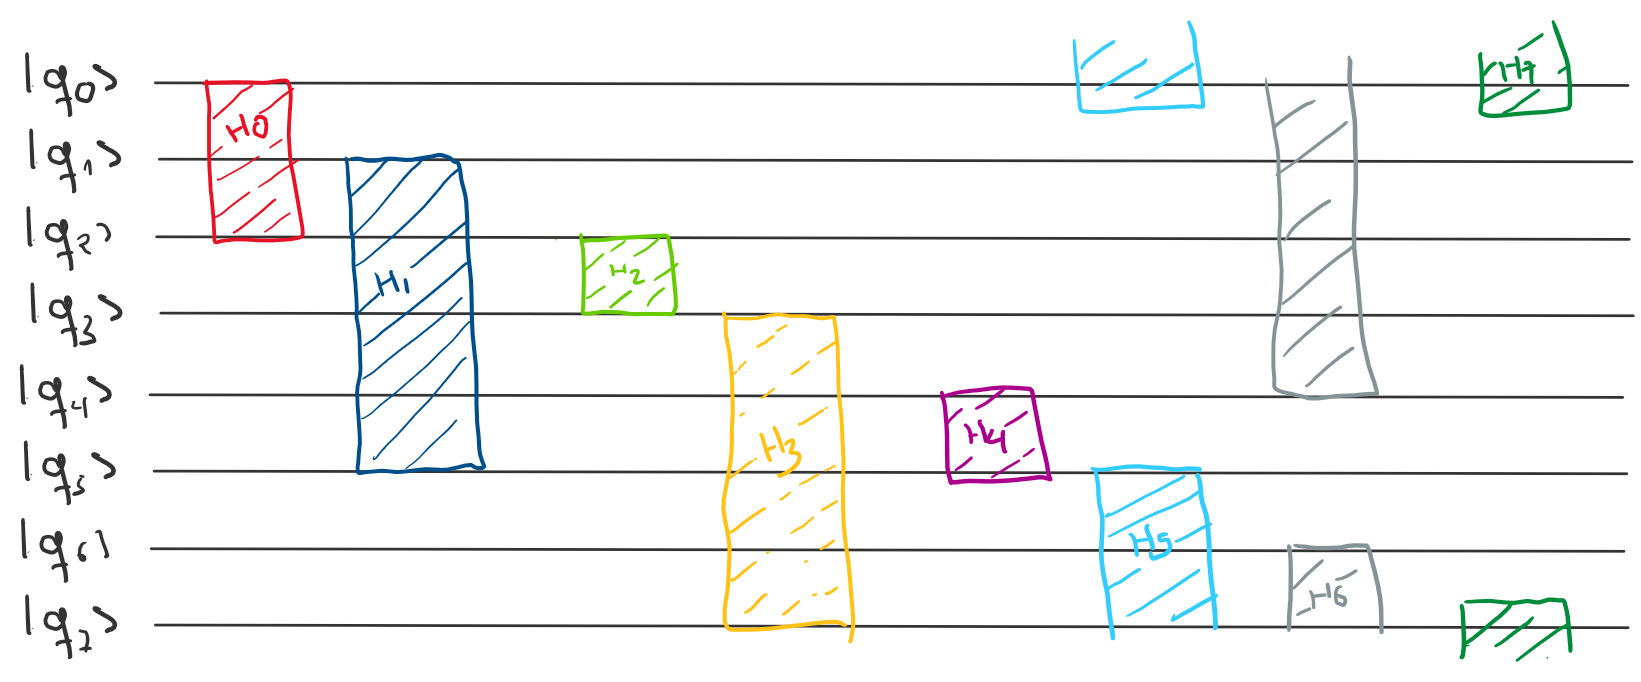


As can be seen each qubit will have its own hamiltonian that affeccts only to qubits near to it. For computing the the local parent hamiltonian following ingredients are needed:

1. The complete state of the ansatz should be computed and organized as a *n*-rank tensor:

$$\ket{\Psi} = \Psi_{i_0 i_1 \cdots i_{n-1}} \ket{i_0 i_1 \cdots i_{n-1}}$$

2. Computation of the reduced density matrix for $m$ consecutive qubits from a fixed qubit $i_k$: $\rho_{k}^m$. All the qubits except the consecutive set of qubits, $\{i_{k}, i_{k+1}, \cdots, i_{k+m}\}$, should be traced out:

$$\rho_{k}^m = \text{Tr}_{i_l \notin \{i_{k}, i_{k+1}, \cdots, i_{k+m}\}} (\rho)  = 
    \rho_{i_{k} i_{k+1} \cdots i_{k+m}}^{j_{k} j_{k+1} \cdots j_{k+m}} = \\
    =\Psi_{\color{red}{i_0i_1} \cdots i_{k} i_{k+1} \cdots i_{k+m} \color{red}{i_{k+m+1} \cdots i_{n-1}}}
    \Psi^{*\;\color{red}{i_0i_1}\cdots j_{k} j_{k+1} \cdots j_{k+m} \color{red}{i_{k+m+1} \cdots i_{n-1}}}$$


The procedure is the following: for each qubit $i_j$ of the ansatz, begining with $j=0$, the nex steps should be exectured by starting with $m_j=1$:

1. Compute the reduced density matrix for qubit $i_j$ and $m_j$, $\rho_{j}^{m_j}$
2. Compute the **rank** of the reduced density matrix $\rho_{j}^{m_j}$: $rank(\rho_{j}^{m_j})$.
3. Determine if the Kernel of the reduced density matrix can be computed:
    1. If $dim(\rho_{j}^{m_j}) = rank(\rho_{j}^{m_j})$, then, the Kernel cannot be computed. Go to step 1 with $m_j = m_j+1$.
    2. If $dim(\rho_{j}^{m_j}) > rank(\rho_{j}^{m_j})$, then, the Kernel can be computed go to step 4.
4. Compute the Kernel of the reduced density matrix, $\text{Kernel}(\rho_{j}^{m_j})$
5. Compute the corresponding projectors from the computed Kernel and sum them all for getting the **local parent Hamiltonian**: $H_{j}^{m_j}$.
6. Compute the linear combination decomposition of $H_{j}^{m_j}$ in the basis of $m_j$-generalized Pauli matrices. For a $H_{j}^{m_j}$, a list of $4^{m_j}$ tuples $(\sigma_I^{j, m_j}, a_I^{j, m_j})$ should be obtained, where $\sigma_I^{j, m_j}$ are all the $m_j$ generalized Pauli matrices and $a_I^{j, m_j}$, the corresponding decomposition coefficients ($I=0, 1, \cdots 4^{m_j}-1$)
7. Repeat the complete process for qubit, $i_{j+1}$ (setting the corresponding $m_{j+1} = 1$) until all qubits are processed.


The **PH** class allows to compute the local Parent Hamiltonian by invoking the **local_ph** method. Following attributes will be populated by this method:

* *reduced_rho*: The reduced local density matrices for each qubit (all the $\rho_{k}^m$).
* *local_free_qubits*:  the qubits affected for each reduced local density matrices (consecutive set of qubits: $\{i_{k}, i_{k+1}, \cdots, i_{k+m}\}$)
* *local_parent_hamiltonians*: Local parent hamiltoninan matrix for each qubit ($H_{j}^{m_j}$)
* *pauli_strings*: pauli strings decomposition of the local Parent Hamiltonian ($\sigma_I^{j, m_j}$)
* *pauli_coeficients*: pauli coeficients for each correspondient Pauli string ($a_I^{j, m_j}$)
* *qubits_list*: list of affected qubits for each correspondient Pauli string ($\{i_{j}, i_{j+1}, \cdots, i_{j+m}\}$)
* *pauli_pdf*: Pandas DataFrame with the Pauli decomposition complete information. 

**BE AWARE**

A prunning procces was done over the Pauli decomposition. Only coefficients which absolute values higher than the float precision (attribute **float_precision**) were kept. Other coefficients are interpret as zero and were removed (the associated Pauli strings were removed too).

In [ ]:
ph_conf = {
    "filename": folder + filename,
    "save": True          
}
ph_object = PH(amplitudes, **ph_conf)

In [ ]:
%%time
ph_object.local_ph()

In [ ]:
# Number of reduced density matrix. MUST BE one for each qubit
len(ph_object.reduced_rho)

In [ ]:
ph_object.reduced_rho[5].shape

In [ ]:
# Affected qubits for each reduced density matrix. MUST BE one for each qubit
len(ph_object.local_free_qubits)

In [ ]:
ph_object.local_free_qubits

In [ ]:
# The local parent hamiltonians for each qubit
len(ph_object.local_parent_hamiltonians)

In [ ]:
ph_object.local_parent_hamiltonians[0].shape

In [ ]:
ph_object.pauli_pdf

Due to the symetries of the **ansatz_qlm_01** the obtained reduced density matrix are equal for all the qubits of the ansazt. But this is not necesary true for other type of ansatzes

In [ ]:
np.isclose(ph_object.reduced_rho[0], ph_object.reduced_rho[1]).all()

### 2.3 Translational invariant of the ansatz

If the ansatz is translational invariant then the computations of the reduced density matrices can be obtained only **for the first qubit** and then used the same reduced density matrix for the other qubits. In this case the time performance of the computation can be boosted.  For doing this kind of computation we have to inilitalize the **PH** class providing the input *t_invariant* with a **True**. 

In this case *reduced_rho*, *local_free_qubits* and *local_parent_hamiltonians* will have only one element.

This apply for the other attributes *pauli_matrices*, *pauli_coeficients*, *qubits_list* and *pauli_pdf*. 


**Now we are going to use the same ansatz for computing the local Parent Hamiltonian but we are going to set t_inv to True indicating that the ansatz is translational invariant. The result MUST be the same but the number of Pauli string will be lower because only computations on the first qubit were done. The complete local Parent Hamiltonian will need to replicate all the Pauli strings (and coeffcients) for all the qubits**


In [ ]:
#setting translational invarinat
ph_conf = {
    "filename": folder + filename+"_invariant",
    "save": True          
}
ph_object_in = PH(amplitudes, t_invariant=True, **ph_conf)

In [ ]:
%%time
ph_object_in.local_ph()

The obtained reduced density matrices , and the affected qubits, will be equal to the obtained matrices with *t_invariant=False*

In [ ]:
# Number of reduced density matrix. MUST BE only one
len(ph_object_in.reduced_rho)

In [ ]:
# Affected qubits for each reduced density matrix. MUST BE only one
len(ph_object_in.local_free_qubits)

In [ ]:
len(ph_object_in.local_parent_hamiltonians)

Now we compare the number of Pauli coeficients when t_inv was set to False (ph_object) and when was set to True (ph_object_in)

In [ ]:
len(ph_object.pauli_coeficients),len(ph_object_in.pauli_coeficients)

However the the Pauli decomposition sould be the same for the first qubit

In [ ]:
# Testing Pauli coefficients for the first qubit for t_inv set to False and t_inv set to True.
np.isclose(
    ph_object.pauli_pdf[:len(ph_object_in.pauli_strings)]["PauliCoefficients"].astype(float),
    ph_object_in.pauli_pdf["PauliCoefficients"].astype(float)
).all()

In [ ]:
# Testing all the Pauli strings for the first qubit  for t_inv set to False and t_inv set to True.
(ph_object.pauli_pdf[:len(ph_object_in.pauli_strings)]['PauliStrings'] == ph_object_in.pauli_pdf["PauliStrings"]).all()

## 3. Example of use with more Ansatzes 

The use of the **PH** class is independent of the ansatz (only the if the ansatz is invariant can be providing to the class in order to boost performance, but this is not mandatory!!). The only mandatory input is the complete amplitudes of the state of the ansatz. 

So any ansatz can be used by the class


In [ ]:
# Ansatz Configuration
ansatz_conf = {
    'nqubits' : 12,
    'depth' : 3
}
ansatz = "simple02"
circuit = ansatz_selector(ansatz, **ansatz_conf)
%qatdisplay circuit --svg

# Solving  Ansatz Configuration
filename = "ansatz_{}_dept_{}_nqubits_{}".format(ansatz, ansatz_conf["depth"], ansatz_conf["nqubits"])
print(filename)
# Create the parameter values
parameters = {v_ : 2 * np.pi * np.random.rand() for i_, v_ in enumerate(circuit.get_variables())}
angles = [k for k, v in parameters.items()]
values = [v for k, v in parameters.items()]
pdf_parameters = pd.DataFrame([angles, values], index=['key', 'value']).T

circuit, parameters_pdf = angles_ansatz01(circuit, pdf_parameters)


solve_conf = {
    'nqubits' : 12,
    "qpu" : qpu_c,
    "parameters" : parameters_pdf,
    "filename": folder + filename,
    "save": True        
}

# Solving Ansatz
solv_ansatz02 = SolveCircuit(circuit, **solve_conf)
solv_ansatz02.run()
amplitudes02 = list(solv_ansatz02.state['Amplitude'])

In [ ]:
ph_conf = {
    "filename": folder + filename,
    "save": True          
}
ph_anstaz02 = PH(amplitudes02, t_invariant=False, **ph_conf)

In [ ]:
# Computes local PH
ph_anstaz02.local_ph()

In this case the matrices for the different qubits will be different. Even they can be of different shapes because the locality can change from qubit to qubit!!

In [ ]:
qubit_j = 0
qubit_k = 1
Equal_Shape = ph_anstaz02.reduced_rho[qubit_j].shape == ph_anstaz02.reduced_rho[qubit_k].shape
print("Are shapes equal: {}".format(Equal_Shape))
if Equal_Shape:
    print(np.isclose(ph_anstaz02.reduced_rho[qubit_j], ph_anstaz02.reduced_rho[qubit_k]).all())

The *local_free_qubits* give us the qubits affected for the local Hamiltonian foreach of the qubits of the ansatz

In [ ]:
ph_anstaz02.local_free_qubits

In [ ]:
ph_anstaz02.pauli_pdf

#### hwe

In [ ]:
# Ansatz Configuration
ansatz_conf = {
    'nqubits' : 12,
    'depth' : 3
}
ansatz = "hwe"
circuit = ansatz_selector(ansatz, **ansatz_conf)
%qatdisplay circuit --svg

# Solving  Ansatz Configuration
filename = "ansatz_{}_dept_{}_nqubits_{}".format(ansatz, ansatz_conf["depth"], ansatz_conf["nqubits"])
print(filename)

# Create the parameter values
parameters = {v_ : 2 * np.pi * np.random.rand() for i_, v_ in enumerate(circuit.get_variables())}
angles = [k for k, v in parameters.items()]
values = [v for k, v in parameters.items()]
pdf_parameters = pd.DataFrame([angles, values], index=['key', 'value']).T

circuit, parameters_pdf = angles_ansatz01(circuit, pdf_parameters)


solve_conf = {
    'nqubits' : 12,    
    "qpu" : qpu_c,
    "parameters" : pdf_parameters,
    "filename": folder + filename,
    "save": True        
}

# Solving Ansatz
solv_hwe = SolveCircuit(circuit, **solve_conf)
solv_hwe.run()
amplitudes_hwe = list(solv_hwe.state['Amplitude'])

In [ ]:
ph_conf = {
    "filename": folder + filename,
    "save": True          
}
ph_hwe = PH(amplitudes_hwe, t_invariant=False, **ph_conf)

In [ ]:
ph_hwe.local_ph()

In [ ]:
ph_hwe.pauli_pdf

## Saving Staff

If save is required the following two files will be generated:

* folder + filename+*_pauli.csv*: where the pauli_pdf attribute is stored
* folder + filename+*_ph_time.csv*: where the time for computing parent hamiltonian is stroed